In [30]:
from datetime import datetime
from pandas import read_csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Loads the full edgelist

In [31]:
# Loads the full edgelist from the games played in May 2022
df = read_csv('../data/2022_05/full_edgelist.csv')

# Converts the entries in column Timestamp into datetime objects
df['Timestamp'] = df.apply(lambda x: datetime.strptime(x['Timestamp'], '%Y-%m-%d  %H:%M:%S'), axis=1)

### Example: extracts an edgelist

In [3]:
for game_to_keep in range(1,7):
    for distance_threshold in range(5, 201, 5):
        df[(df.Game==game_to_keep) & (df.distance < distance_threshold)].sort_values('Timestamp').to_csv(
              '../data/2022_05/thresholded_edgelists/edgelist_game{}_thresh{}.csv'.format(game_to_keep, distance_threshold),
              index=False,
              columns=['Timestamp', 'Player_ID_1', 'Player_ID_2'])        

### Extract edgelist for DyNetVis

In [9]:
import numpy as np
import pandas as pd

for game_to_keep in range(1,7):
    for distance_threshold in range(5, 26, 5):
        filtered_df = df[(df.Game==game_to_keep) & (df.distance < distance_threshold)].sort_values('Timestamp')

        copy = filtered_df.copy()

        # Change Player_ID to int
        playerID_to_int = {}
        for n, name in enumerate(np.unique(copy[['Player_ID_1', 'Player_ID_2']].values)):
            playerID_to_int[name] = n+1
        copy.replace({'Player_ID_1':playerID_to_int, 'Player_ID_2':playerID_to_int}, inplace=True)

        # Change Timestamp to int
        start_time = filtered_df.values[0][1]
        copy.Timestamp = (filtered_df.Timestamp - start_time).astype('int64')
        copy.Timestamp = (copy.Timestamp / 1e9).astype('int32')

        copy.rename(columns={"Player_ID_1": "Node 1 ID", "Player_ID_2": "Node 2 ID", "Timestamp": "Time"}, inplace=True)

        copy.to_csv('../data/2022_05/DyNetVis_edgelists/edgelist_game{}_thresh{}.csv'.format(game_to_keep, distance_threshold),
                    index=False,
                    sep=' ',
                    columns=['Node 1 ID', 'Node 2 ID', 'Time'],
                    header=True)

In [111]:
# Make metadata from last csv (for DyNetVis only)
player_df = read_csv('../data/2022_05/Player_data.csv', sep=';')
game_groups = player_df.groupby(["Game"])
game_df = game_groups.get_group(game_to_keep).copy()
game_df["Node ID"] = game_df["Player_ID"].map(playerID_to_int)
game_df.rename(columns={"Role": "Metadata"}, inplace=True)
game_df = game_df.sort_values("Metadata")

game_df.to_csv('../data/2022_05/edgelists_csv_DyNetVis/metadata_game{}_thresh{}.csv'.format(game_to_keep, distance_threshold),
                index=False,
                sep=' ',
                columns=["Node ID", "Metadata"])

### Extract edglist for Snap

In [88]:
def create_int_to_role_dict(player_df, game, playerID_to_int):
    int_to_role_dict = {}
    game_groups = player_df.groupby(["Game"])
    game_player_df = game_groups.get_group(game)
    player_role_dict = pd.Series(game_player_df.Role.values,index=game_player_df.Player_ID).to_dict()
    for player in player_role_dict:
        if player_role_dict[player] == 'Apex':
            if player in playerID_to_int:
                int_to_role_dict[playerID_to_int[player]] = 2
        elif player_role_dict[player] == 'Meso':
            if player in playerID_to_int:
                int_to_role_dict[playerID_to_int[player]] = 1
        else:
            if player in playerID_to_int:
                int_to_role_dict[playerID_to_int[player]] = 0
    return int_to_role_dict

In [89]:
import numpy as np
import pandas as pd

for game_to_keep in range(1,7):
    for distance_threshold in range(5, 26, 5):
        filtered_df = df[(df.Game==game_to_keep) & (df.distance < distance_threshold)].sort_values('Timestamp')

        copy = filtered_df.copy()

        # Change Player_ID to int
        playerID_to_int = {}
        for n, name in enumerate(np.unique(copy[['Player_ID_1', 'Player_ID_2']].values)):
            playerID_to_int[name] = n+1
        copy.replace({'Player_ID_1':playerID_to_int, 'Player_ID_2':playerID_to_int}, inplace=True)
        
        # Create list of Apex and list of Mesos
        player_df = pd.read_csv("../data/2022_05/Player_data.csv", sep=';')
        int_to_role_dict = create_int_to_role_dict(player_df, game_to_keep, playerID_to_int)
                
        # Duplicate and orient edges
        copy["Role1"] = copy["Player_ID_1"].map(int_to_role_dict)
        copy["Role2"] = copy["Player_ID_2"].map(int_to_role_dict)
        copy["Role_Comparison"] = copy["Role1"] - copy["Role2"]        
        # Give the right orientation (Apex -> Meso -> Prey)
        mask = (copy['Role_Comparison'] <= 1)
        copy.loc[mask, ['Player_ID_1', 'Player_ID_2']] = copy[mask][['Player_ID_1', 'Player_ID_2']].values.astype(int)
        # Duplicate edges between the same trophic level
        rows_to_duplicate = copy[copy["Role_Comparison"] == 0]
        rows_to_duplicate = rows_to_duplicate.rename(columns={'Player_ID_1': 'Player_ID_2', 'Player_ID_2': 'Player_ID_1'})
        copy = pd.concat([copy, rows_to_duplicate])
        
        # Change Timestamp to int
        start_time = filtered_df.values[0][1]
        copy.Timestamp = (filtered_df.Timestamp - start_time).astype('int64')
        copy.Timestamp = (copy.Timestamp / 1e9).astype('int32')
        
        copy = copy.sort_values('Timestamp')
        copy.rename(columns={"Player_ID_1": "Node 1 ID", "Player_ID_2": "Node 2 ID", "Timestamp": "Time"}, inplace=True)
                
        copy.to_csv('../data/2022_05/snap_edgelists/edgelist_game{}_thresh{}.txt'.format(game_to_keep, distance_threshold),
                    index=False,
                    sep=' ',
                    columns=['Node 1 ID', 'Node 2 ID', 'Time'],
                    header=None)

# Égoportraits et sous-graphes de chasse

In [32]:
def get_role_lists(noderole_dict):
    preys = []
    mesos = []
    apexes = []
    for key in noderole_dict:
        if noderole_dict[key]=='Prey':
            preys.append(key)
        elif noderole_dict[key]=='Meso':
            mesos.append(key)
        elif noderole_dict[key]=='Apex':
            apexes.append(key)
    return preys, mesos, apexes


def get_death_time(game_to_keep, victim):
    rp_df = pd.read_csv("../data/2022_05/real_positions.csv")
    rp_df['Timestamp'] = rp_df.apply(lambda x: datetime.strptime(x['Timestamp'], '%Y-%m-%d  %H:%M:%S'), axis=1)
    death_time = np.max(rp_df[(rp_df.Game == game_to_keep) & (rp_df.Player_ID == victim)].Timestamp.values)
    return death_time

def get_egoportrait(ego, death_window_df):    
    # Filter the relevant data
    egoportrait_df = death_window_df[(death_window_df.Player_ID_1 == ego) | (death_window_df.Player_ID_2 == ego)].copy()
    
    # Create and fill the egoportrait (dictionary)
    egoportrait_dict = {}
    groups = egoportrait_df.groupby(['Player_ID_1', 'Player_ID_2'])
    for group_id, group_df in groups:
        if group_id[0] == ego:
            alter = group_id[1]
        else:
            alter = group_id[0]
        egoportrait_dict[alter] = group_df['inverse_distance'].sum()
    return egoportrait_dict

In [33]:
game_to_keep = 4
# distance_threshold = 100
time_window = 20
time_delta = np.timedelta64(time_window, 's')

game_df = df[(df.Game==game_to_keep)].sort_values('Timestamp')

player_df = pd.read_csv("../data/2022_05/Player_data.csv", sep=';')
game_player_df = player_df[player_df.Game==game_to_keep]

egoportraits = []
# Iterate on all players
for victim, killer in zip(game_player_df.Player_ID, game_player_df.Killed_by):
    if not pd.isna(killer):  # Filter the players that were killed by a predator
        death_time = get_death_time(game_to_keep, victim)
        print(death_time, victim, killer)
    
        death_window_df = game_df[(game_df.Timestamp >= death_time - time_delta) & (game_df.Timestamp <= death_time)].copy()
        death_window_df['inverse_distance'] = 1/death_window_df['distance']
        
        victim_egoportrait = get_egoportrait(victim, death_window_df)
        killer_egoportrait = get_egoportrait(killer, death_window_df)
        egoportraits.append((victim, killer, victim_egoportrait, killer_egoportrait))

2022-05-11T17:59:53.000000000 MZ MTP
2022-05-11T17:53:56.000000000 PL MZ
2022-05-11T18:05:51.000000000 MWB MTP
2022-05-11T17:59:56.000000000 DB MZ


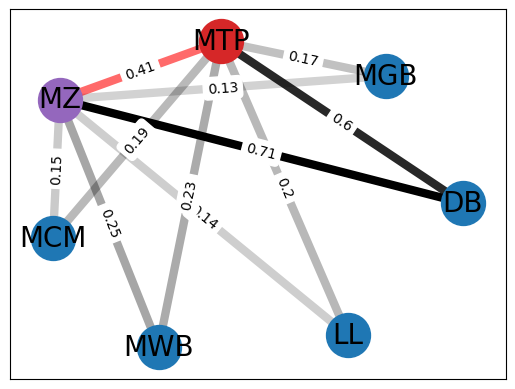

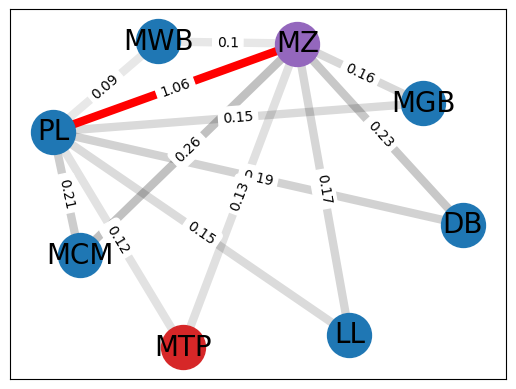

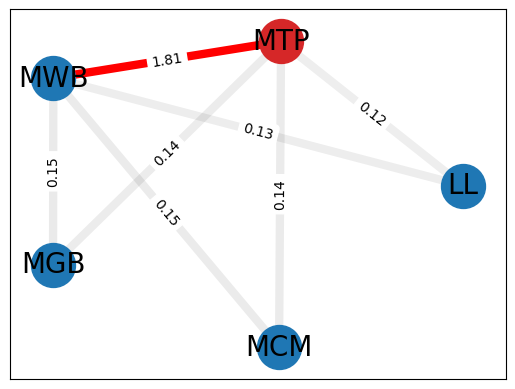

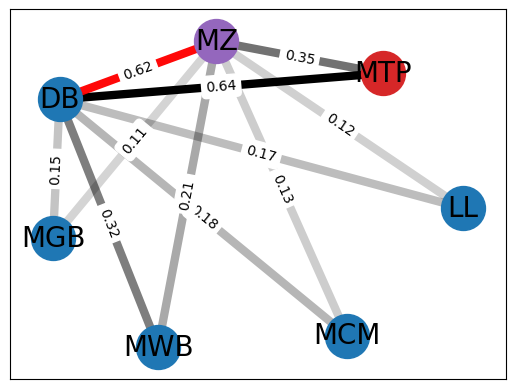

In [34]:
import networkx as nx

player_df = pd.read_csv("../data/2022_05/Player_data.csv", sep=';')
player_df = player_df[player_df.Game==game_to_keep]
player_role_dict = pd.Series(player_df.Role.values,index=player_df.Player_ID).to_dict()

for victim, killer, victim_egoportrait, killer_egoportrait in egoportraits:
    G = nx.Graph()
    G.add_node(victim, role=player_role_dict[victim])
    G.add_node(killer, role=player_role_dict[killer])
    for alter in victim_egoportrait:
        G.add_node(alter, role=player_role_dict[alter])
        G.add_edge(victim, alter, weight=victim_egoportrait[alter])
    for alter in killer_egoportrait:
        G.add_node(alter, role=player_role_dict[alter])
        G.add_edge(killer, alter, weight=killer_egoportrait[alter])
    
    pos = nx.spring_layout(G, seed=7, k=4)  # positions for all nodes - seed for reproducibility - ideal distance
    
    noderole_dict = nx.get_node_attributes(G, 'role')
    preys, mesos, apexes = get_role_lists(noderole_dict)
    nx.draw_networkx_nodes(G, pos, nodelist=preys, node_color ='tab:blue', node_size=1000)
    nx.draw_networkx_nodes(G, pos, nodelist=mesos, node_color='tab:purple', node_size=1000)
    nx.draw_networkx_nodes(G, pos, nodelist=apexes, node_color='tab:red', node_size=1000)
    
    edgeweight_list = []
    edgeweight_dict = nx.get_edge_attributes(G, "weight")
    for edge in edgeweight_dict:
        edgeweight_list.append(edgeweight_dict[edge])
    edgealpha = np.array(edgeweight_list)
    edgealpha /= np.max(edgealpha)
    edgealpha = list(edgealpha)
    edgelist = list(G.edges())
    death_edge = (victim, killer)
    death_index = edgelist.index(death_edge)
    edgelist.remove(death_edge)
    death_alpha = edgealpha[death_index]
    edgealpha.remove(death_alpha)
    
    nx.draw_networkx_edges(G, pos, width=6, edgelist=edgelist, alpha=edgealpha)
    nx.draw_networkx_edges(G, pos, edgelist=[death_edge], edge_color='red', width=6, alpha=[death_alpha])
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    edge_labels = edgeweight_dict
    for key in edge_labels:
        edge_labels[key] = round(edge_labels[key], 2)
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
    plt.show()